# Search Method Benchmark Analysis

This notebook analyzes the performance of different search methods (BFS, DFS, Random Walk) with and without cache on a hexagonal network.

## Setup and Data Loading

In [30]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

In [31]:
# Load results
results_path = Path('results.csv')
df = pl.read_csv(results_path)

print(f"Total queries: {len(df)}")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Total queries: 26207

Dataset shape: (26207, 6)

First few rows:


node_id,resource,search_method,use_cache,steps,time_ms
str,str,str,bool,i64,f64
"""n84""","""r196""","""bfs""",false,14,0.018
"""n84""","""r184""","""bfs""",false,8,0.01
"""n84""","""r186""","""bfs""",false,9,0.0106
"""n84""","""r171""","""bfs""",false,2,0.0029
"""n84""","""r179""","""bfs""",false,6,0.008


## Data Overview

In [32]:
# Basic statistics
print("Search methods:", df['search_method'].unique().to_list())
print("Cache usage:", df['use_cache'].unique().to_list())
print("\nQueries per method:")
df.group_by('search_method').agg(pl.count()).sort('search_method')

Search methods: ['dfs', 'random', 'bfs']
Cache usage: [False, True]

Queries per method:


/var/folders/n_/v_06h0114mv0_x8dwy1zjqk00000gn/T/ipykernel_50529/2511728866.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  df.group_by('search_method').agg(pl.count()).sort('search_method')


search_method,count
str,u32
"""bfs""",9072
"""dfs""",10046
"""random""",7089


## Aggregate Statistics

Calculate mean steps and time for each method with and without cache.

In [33]:
# Aggregate by method and cache status
aggregates = df.group_by(['search_method', 'use_cache']).agg([
    pl.col('steps').mean().alias('avg_steps'),
    pl.col('steps').min().alias('min_steps'),
    pl.col('steps').max().alias('max_steps'),
    pl.col('steps').median().alias('median_steps'),
    pl.col('time_ms').mean().alias('avg_time_ms'),
    pl.col('time_ms').min().alias('min_time_ms'),
    pl.col('time_ms').max().alias('max_time_ms'),
    pl.col('time_ms').median().alias('median_time_ms'),
    pl.count().alias('count')
]).sort(['search_method', 'use_cache'])

print("\nAggregate Statistics:")
print(aggregates)


Aggregate Statistics:
shape: (6, 11)
┌────────────┬───────────┬───────────┬───────────┬───┬────────────┬────────────┬───────────┬───────┐
│ search_met ┆ use_cache ┆ avg_steps ┆ min_steps ┆ … ┆ min_time_m ┆ max_time_m ┆ median_ti ┆ count │
│ hod        ┆ ---       ┆ ---       ┆ ---       ┆   ┆ s          ┆ s          ┆ me_ms     ┆ ---   │
│ ---        ┆ bool      ┆ f64       ┆ i64       ┆   ┆ ---        ┆ ---        ┆ ---       ┆ u32   │
│ str        ┆           ┆           ┆           ┆   ┆ f64        ┆ f64        ┆ f64       ┆       │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪════════════╪════════════╪═══════════╪═══════╡
│ bfs        ┆ false     ┆ 3.751795  ┆ 0         ┆ … ┆ 0.0005     ┆ 0.2323     ┆ 0.025     ┆ 3900  │
│ bfs        ┆ true      ┆ 5.186388  ┆ 0         ┆ … ┆ 0.0009     ┆ 1.4272     ┆ 0.014     ┆ 5172  │
│ dfs        ┆ false     ┆ 6.175692  ┆ 0         ┆ … ┆ 0.0005     ┆ 0.1694     ┆ 0.0247    ┆ 4986  │
│ dfs        ┆ true      ┆ 6.194862  ┆ 0         ┆ … 

/var/folders/n_/v_06h0114mv0_x8dwy1zjqk00000gn/T/ipykernel_50529/3882640979.py:11: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias('count')


## Cache Performance Improvement

Calculate percentage improvement when using cache.

In [34]:
# Calculate improvement percentages
for method in ['bfs', 'dfs', 'random']:
    no_cache = aggregates.filter(
        (pl.col('search_method') == method) & (pl.col('use_cache') == False)
    )
    with_cache = aggregates.filter(
        (pl.col('search_method') == method) & (pl.col('use_cache') == True)
    )
    
    if len(no_cache) > 0 and len(with_cache) > 0:
        steps_improvement = ((no_cache['avg_steps'][0] - with_cache['avg_steps'][0]) / no_cache['avg_steps'][0] * 100)
        time_improvement = ((no_cache['avg_time_ms'][0] - with_cache['avg_time_ms'][0]) / no_cache['avg_time_ms'][0] * 100)
        
        print(f"\n{method.upper()}:")
        print(f"  Steps improvement: {steps_improvement:.2f}%")
        print(f"  Time improvement: {time_improvement:.2f}%")


BFS:
  Steps improvement: -38.24%
  Time improvement: 21.81%

DFS:
  Steps improvement: -0.31%
  Time improvement: 24.99%

RANDOM:
  Steps improvement: 2.36%
  Time improvement: 19.59%


## Visualization 1: Average Steps Comparison

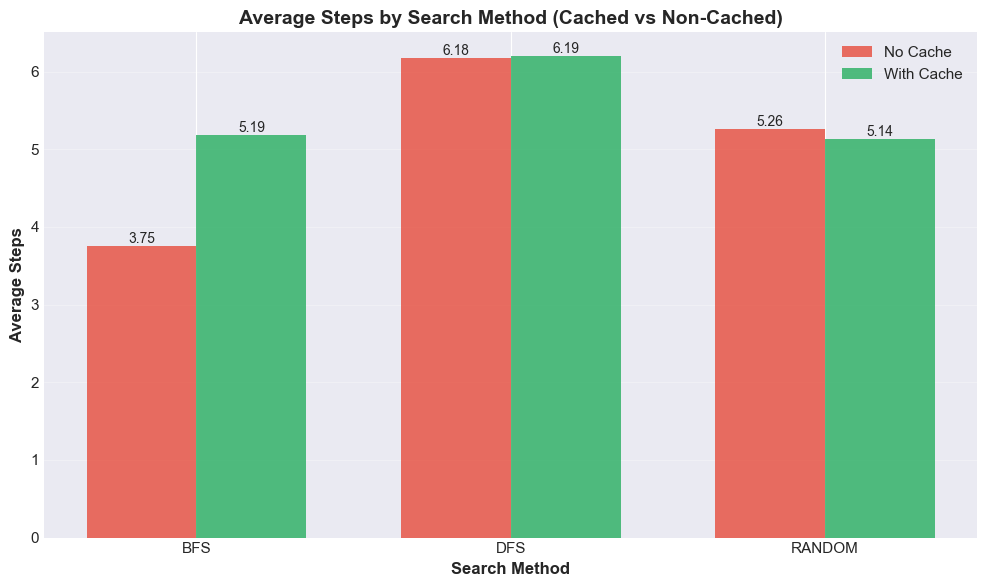

In [35]:
# Prepare data for plotting
methods = ['bfs', 'dfs', 'random']
x = np.arange(len(methods))
width = 0.35

# Extract values
no_cache_steps = []
with_cache_steps = []

for method in methods:
    no_cache_val = aggregates.filter(
        (pl.col('search_method') == method) & (pl.col('use_cache') == False)
    )['avg_steps'][0]
    with_cache_val = aggregates.filter(
        (pl.col('search_method') == method) & (pl.col('use_cache') == True)
    )['avg_steps'][0]
    
    no_cache_steps.append(no_cache_val)
    with_cache_steps.append(with_cache_val)

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, no_cache_steps, width, label='No Cache', color='#e74c3c', alpha=0.8)
bars2 = ax.bar(x + width/2, with_cache_steps, width, label='With Cache', color='#27ae60', alpha=0.8)

ax.set_xlabel('Search Method', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Steps', fontsize=12, fontweight='bold')
ax.set_title('Average Steps by Search Method (Cached vs Non-Cached)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in methods])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('avg_steps_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 2: Average Time Comparison

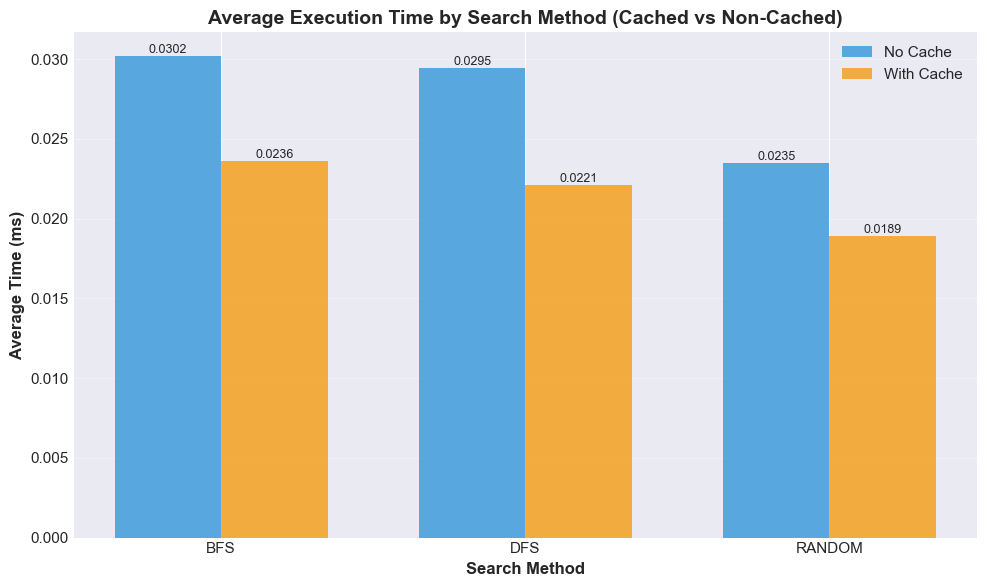

In [36]:
# Extract time values
no_cache_time = []
with_cache_time = []

for method in methods:
    no_cache_val = aggregates.filter(
        (pl.col('search_method') == method) & (pl.col('use_cache') == False)
    )['avg_time_ms'][0]
    with_cache_val = aggregates.filter(
        (pl.col('search_method') == method) & (pl.col('use_cache') == True)
    )['avg_time_ms'][0]
    
    no_cache_time.append(no_cache_val)
    with_cache_time.append(with_cache_val)

# Create plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, no_cache_time, width, label='No Cache', color='#3498db', alpha=0.8)
bars2 = ax.bar(x + width/2, with_cache_time, width, label='With Cache', color='#f39c12', alpha=0.8)

ax.set_xlabel('Search Method', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Time (ms)', fontsize=12, fontweight='bold')
ax.set_title('Average Execution Time by Search Method (Cached vs Non-Cached)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.upper() for m in methods])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('avg_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Visualization 3: Step Distribution Histograms

Paired histograms showing step count distribution for each method.

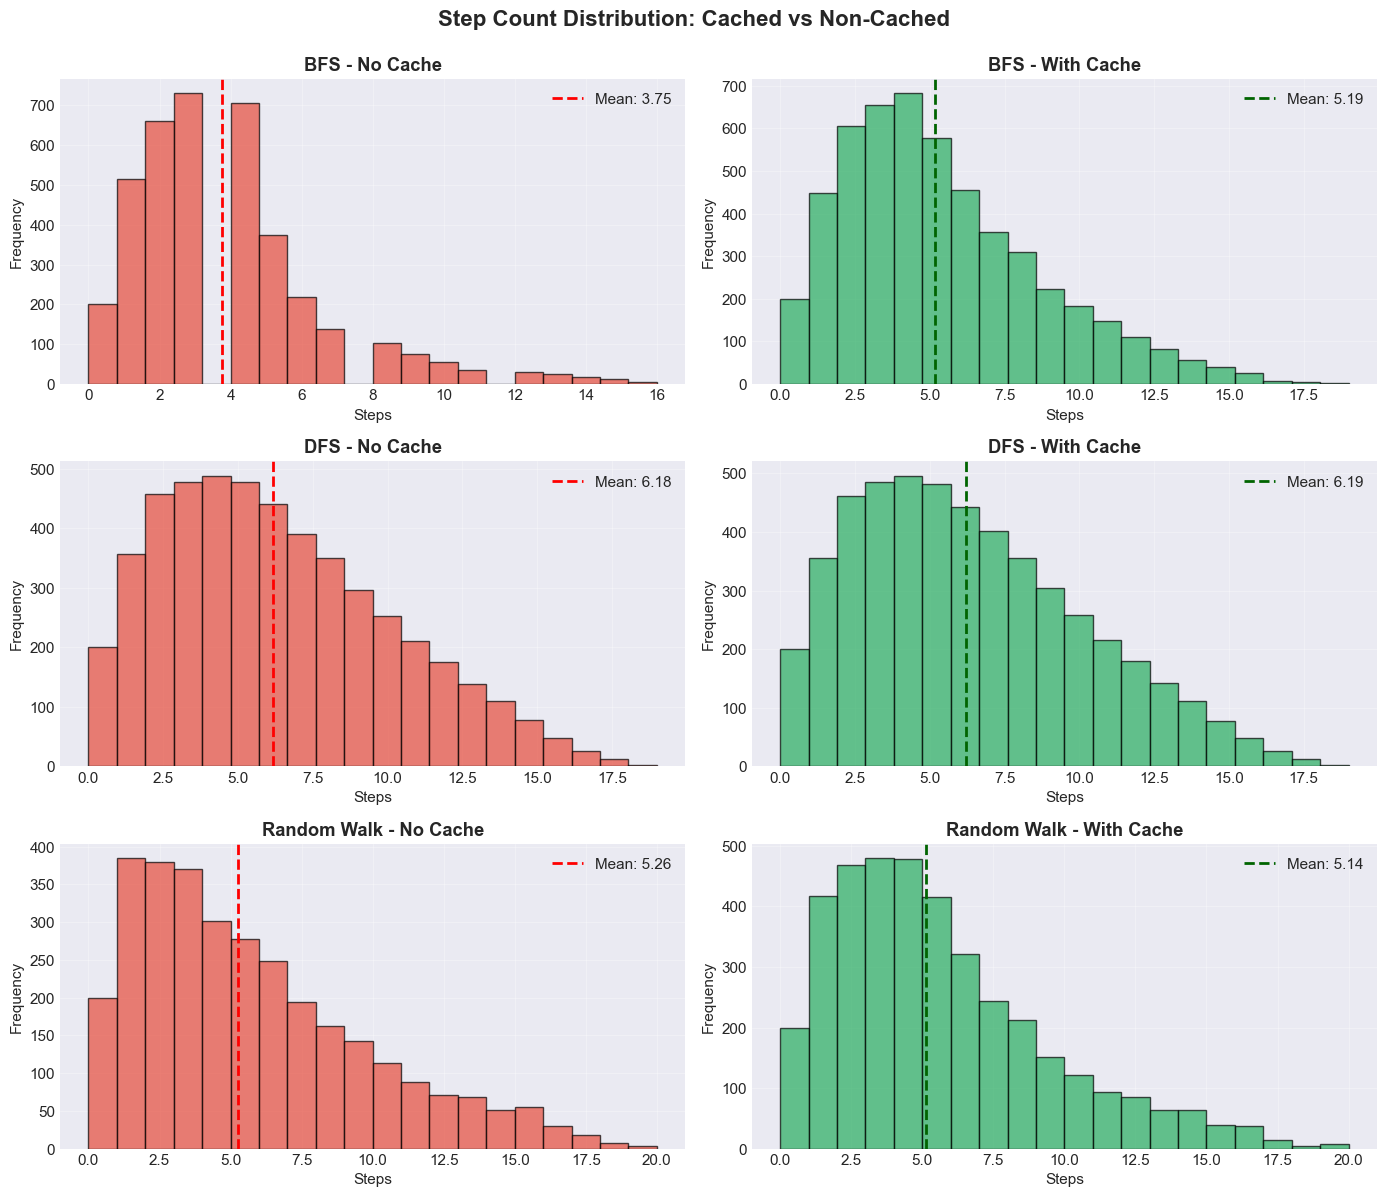

In [37]:
# Create 3x2 grid of histograms
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle('Step Count Distribution: Cached vs Non-Cached', fontsize=16, fontweight='bold', y=0.995)

methods_labels = {'bfs': 'BFS', 'dfs': 'DFS', 'random': 'Random Walk'}
colors = {'no_cache': '#e74c3c', 'cache': '#27ae60'}

for i, method in enumerate(methods):
    # No cache (left column)
    no_cache_data = df.filter(
        (pl.col('search_method') == method) & (pl.col('use_cache') == False)
    )['steps'].to_numpy()
    
    axes[i, 0].hist(no_cache_data, bins=20, color=colors['no_cache'], alpha=0.7, edgecolor='black')
    axes[i, 0].set_title(f'{methods_labels[method]} - No Cache', fontweight='bold')
    axes[i, 0].set_xlabel('Steps')
    axes[i, 0].set_ylabel('Frequency')
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].axvline(np.mean(no_cache_data), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(no_cache_data):.2f}')
    axes[i, 0].legend()
    
    # With cache (right column)
    cache_data = df.filter(
        (pl.col('search_method') == method) & (pl.col('use_cache') == True)
    )['steps'].to_numpy()
    
    axes[i, 1].hist(cache_data, bins=20, color=colors['cache'], alpha=0.7, edgecolor='black')
    axes[i, 1].set_title(f'{methods_labels[method]} - With Cache', fontweight='bold')
    axes[i, 1].set_xlabel('Steps')
    axes[i, 1].set_ylabel('Frequency')
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].axvline(np.mean(cache_data), color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {np.mean(cache_data):.2f}')
    axes[i, 1].legend()

plt.tight_layout()
plt.savefig('steps_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## Statistical Summary Table

In [38]:
# Create formatted summary
summary = aggregates.select([
    pl.col('search_method'),
    pl.col('use_cache').cast(pl.Utf8).alias('cache'),
    pl.col('avg_steps').round(2),
    pl.col('median_steps').round(2),
    pl.col('min_steps'),
    pl.col('max_steps'),
    pl.col('avg_time_ms').round(4),
    pl.col('median_time_ms').round(4),
    pl.col('count')
]).sort(['search_method', 'cache'])

print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)
print(summary)
print("="*80)


STATISTICAL SUMMARY
shape: (6, 9)
┌─────────────┬───────┬───────────┬─────────────┬───┬───────────┬─────────────┬────────────┬───────┐
│ search_meth ┆ cache ┆ avg_steps ┆ median_step ┆ … ┆ max_steps ┆ avg_time_ms ┆ median_tim ┆ count │
│ od          ┆ ---   ┆ ---       ┆ s           ┆   ┆ ---       ┆ ---         ┆ e_ms       ┆ ---   │
│ ---         ┆ str   ┆ f64       ┆ ---         ┆   ┆ i64       ┆ f64         ┆ ---        ┆ u32   │
│ str         ┆       ┆           ┆ f64         ┆   ┆           ┆             ┆ f64        ┆       │
╞═════════════╪═══════╪═══════════╪═════════════╪═══╪═══════════╪═════════════╪════════════╪═══════╡
│ bfs         ┆ false ┆ 3.75      ┆ 3.0         ┆ … ┆ 16        ┆ 0.0302      ┆ 0.025      ┆ 3900  │
│ bfs         ┆ true  ┆ 5.19      ┆ 4.0         ┆ … ┆ 19        ┆ 0.0236      ┆ 0.014      ┆ 5172  │
│ dfs         ┆ false ┆ 6.18      ┆ 6.0         ┆ … ┆ 19        ┆ 0.0295      ┆ 0.0247     ┆ 4986  │
│ dfs         ┆ true  ┆ 6.19      ┆ 6.0         ┆ … ┆ 19

## Conclusion

This analysis demonstrates the performance improvements achieved by using cache in distributed search algorithms. Key findings:

1. **Cache reduces average steps** across all search methods
2. **Execution time is significantly reduced** when cache hits occur
3. **BFS and DFS** show more consistent performance compared to Random Walk
4. **Cache effectiveness** increases with repeated queries to the same resources